# Capstone Project: Classifying clinically actionable genetic mutations

***

## Notebook 4: Alternative Models

This notebook contains code to explore alternative models to address the classification problem.

### Contents

- [Importing of Libraries](#Importing-of-Libraries)
- [Data Import](#Data-Import)

## Importing of Libraries

In [79]:
import pandas as pd
import numpy as np

from tabulate import tabulate
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict

TRAIN_SET_PATH = "../assets/train_prep.csv"

GLOVE_6B_50D_PATH = "../assets/glove.6B.50d.txt"
GLOVE_6B_300D_PATH = "../assets/glove.6B.300d.txt"
encoding="utf-8"

BERT_INIT_CHKPNT = "../assets/cased_L-12_H-768_A-12/bert.model.ckpt.index"
BERT_VOCAB = "../assets/cased_L-12_H-768_A-12/vocab.txt"
BERT_CONFIG = "../assets/cased_L-12_H-768_A-12/bert_config.json"

from sklearn import linear_model, metrics, svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report
from sklearn.multiclass import OneVsRestClassifier

from imblearn.over_sampling import SMOTE

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
plt.style.use('fivethirtyeight')

import time
import datetime
import pickle
import os

import nltk
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, LSTM, Embedding, SpatialDropout1D, Flatten
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
# import tensorflow as tf
import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()
import tensorflow_hub as hub

from wordcloud import WordCloud

import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from bert import modeling

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Initialise random seeed for more consistent results
from numpy.random import seed
seed(42)

## Data Import

In [2]:
# Import 'train_prep' and 'test_prep' datasets
# We use the 'keep_default_na' option to False to ensure that pandas does not re-introduce missing values
train = pd.read_csv("../assets/train_prep.csv", keep_default_na=False)
test = pd.read_csv("../assets/test_prep.csv", keep_default_na=False)

In [3]:
train.shape, test.shape

((3321, 4325), (986, 4324))

In [4]:
train.head(2)

,id,class,text,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,...,variation_YAP1-TFE3 Fusion,variation_YWHAE-ROS1 Fusion,variation_ZC3H7B-BCOR Fusion,variation_ZNF198-FGFR1 Fusion,variation_null1313Y,variation_null189Y,variation_null262Q,variation_null267R,variation_null399R,variation_p61BRAF
0,0,1,cyclin dependent kinase cdks regulate variety ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,abstract background non small lung nsclc heter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head(2)

,id,text,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,gene_AGXT,...,variation_YAP1-TFE3 Fusion,variation_YWHAE-ROS1 Fusion,variation_ZC3H7B-BCOR Fusion,variation_ZNF198-FGFR1 Fusion,variation_null1313Y,variation_null189Y,variation_null262Q,variation_null267R,variation_null399R,variation_p61BRAF
0,1,incidence breast increase china recent decade ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,unselected series colorectal carcinoma stratif...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Preparation for Modelling

In [6]:
# Splitting of data into Predictor (X) and Target (y) Dataframes
X = train[[i for i in train.columns if i not in ['id', 'class']]]
y = train['class']

In [7]:
X.shape, y.shape

((3321, 4323), (3321,))

In [8]:
# Save copies of the original X and y dataframes so that we can try different word embeddings as needed
X_original = X.copy()
y_original = y.copy()

In [9]:
X_test = test.drop(['id'], axis=1)

In [10]:
X_test.shape

(986, 4323)

In [11]:
%%time
# For convenience, we create an array called 'X_all_text that contains
# all the text from our training set, across all samples
X_all_text = []
for text in X['text']:
    X_all_text.append(text.split())
X_all_text = np.array(X_all_text)

Wall time: 6.17 s


In [12]:
X_all_text.shape

(3321,)

In [13]:
# Create a set of all the unique words from our taining set, across all samples
X_unique_words = set()
for row in range(len(X_all_text)):
    X_unique_words.update(X_all_text[row])

In [14]:
len(X_unique_words)

81312

In [15]:
max_phrase_len = 0
for row in range(len(X_all_text)):
    if len(X_all_text[row]) > max_phrase_len:
        max_phrase_len = len(X_all_text[row])

In [16]:
max_phrase_len

44019

## Exploring alternative word embeddings

In this notebook, we evaluate various word embeddings other than the ones created using the standard TfidfVectorizer as used in the baseline model.

### Evaluation Approach

To manage the overall processing power needed to find the best alternative model, we seek to find the best alternative model based on the folowing steps:
1. Find an alternative set of word embeddings but use a fixed classifier (Extra Trees Classifier) to measure their performance against our validation dataset
2. Find the best classifier for our chosen word embeddings

For **Step 1** above, we explore three static word embeddings to see if we can get better classification results:
- Global Vectors for Word Representation (GloVe) pre-trained word embeddings created by the [Stanford Natural Language Processing Group](https://nlp.stanford.edu/) and available at https://nlp.stanford.edu/projects/glove/:
    - A smaller set of GloVe embeddings (which we call **'glove_small'**) that are based on based on Wikipedia 2015 and Gigaword 5th Edition (https://catalog.ldc.upenn.edu/LDC2011T07)
    - A larger set of GloVe embeddings (which we call **'glove_big'**) that are based on Common Crawl (https://commoncrawl.org/)
- Our own word embeddings created by training Word2Vec (from nltk) on all the given text in the training dataset, which we call **'w2v'**.

For **Step 2** above, we evaluate the performance of a Forward Neural Network (FNN) and an Extra Trees Classifier. For both classifiers, we use RandomisedSearchCV to find the set of optimal parameters to give the best cross-validated score based on the training dataset.

### Loading of pre-trained word embeddings based on GloVe

We now load the two pre-trained word embeddings (based on GloVe) and store them as dictionary objects 'glove_small' and 'glove_big'.

In [17]:
%%time
import struct 

# glove_small keys are bounded by what is common to both the X_all_text and the glove file
glove_small = {}
all_words = set(w for words in X_all_text for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

# glove_big keys are bounded by what is common to both the X_all_text and the glove file
glove_big = {}
with open(GLOVE_6B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if word in all_words:
            nums=np.array(parts[1:], dtype=np.float32)
            glove_big[word] = nums

Wall time: 36.5 s


### Loading of ELMo word embeddings based on training dataset vocabulary

We load the ELMo module (version 3) from TensorFlow Hub. The ELMo module computes contextualized word representations using character-based word representations and bidirectional LSTMs. 

The module supports inputs both in the form of raw text strings or tokenized text strings. It outputs fixed embeddings at each LSTM layer, a learnable aggregation of the 3 layers, and a fixed mean-pooled vector representation of the input.

In [32]:
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

INFO:absl:Using C:\Users\yuchy\AppData\Local\Temp\tfhub_modules to cache modules.


We define a function that will extract the ELMo vectors of all the words in a single sample and take their mean.

In [33]:
def elmo_vectors(x):
    embeddings = elmo(x, signature="default", as_dict=True)["elmo"]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        # return average of ELMo features
        return sess.run(tf.reduce_mean(embeddings,1))

We now call the function for each sample text in the X_all_text list we have created earlier. Due to memory constraints, we cannot store the entire set of ELMo vectors in memory. Instead, we write them to disk using the Pickle serialisation library using the most efficient Pickle serialisation protocol available. 

In [34]:
%%time
num_rows = len(X_all_text)
block_size = 500
first_start = time.time()
for row in range(num_rows):
    row_start = time.time()
    df = pd.DataFrame(elmo_vectors(X_all_text[row]))
    output_file_name = "../assets/elmo_vectors_" + str((row//block_size)*block_size) + ".csv"
    df.to_csv(output_file_name, mode='a')
    print ("Row {} of {} appended, duration (h:m:s): {}, total elapsed time (h:m:s): {}".format(row+1, num_rows+1,
               str(datetime.timedelta(seconds=time.time()-row_start)),
               str(datetime.timedelta(seconds=time.time()-first_start))))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 1 of 3322 appended, duration (h:m:s): 0:00:25.530810, total elapsed time (h:m:s): 0:00:25.531809
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 2 of 3322 appended, duration (h:m:s): 0:00:20.376989, total elapsed time (h:m:s): 0:00:45.913782
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 3 of 3322 appended, duration (h:m:s): 0:00:20.064077, total elapsed time (h:m:s): 0:01:05.978859
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 4 of 3322 appended, duration (h:m:s): 0:00:23.705412, total elapsed time (h:m:s): 0:01:29.685272
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 5 of 3322 appended, duration (h:m:s): 0:00:39.550117, total elapsed time (h:m:s): 0:02:09.237384
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 6 of 3322 appended, duration (h:m:s): 0:00:25.455503, total elapsed time (h:m:s): 0:02:34.699868
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 7 of 3322 appended, duration (h:m:s): 0:00:24.422882, total elapsed time (h:m:s): 0:02:59.122751
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 8 of 3322 appended, duration (h:m:s): 0:00:54.837268, total elapsed time (h:m:s): 0:03:53.961015
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 9 of 3322 appended, duration (h:m:s): 0:00:43.936094, total elapsed time (h:m:s): 0:04:37.897109
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 10 of 3322 appended, duration (h:m:s): 0:00:27.447700, total elapsed time (h:m:s): 0:05:05.347327
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 11 of 3322 appended, duration (h:m:s): 0:00:22.646472, total elapsed time (h:m:s): 0:05:27.993798
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 12 of 3322 appended, duration (h:m:s): 0:00:53.082122, total elapsed time (h:m:s): 0:06:21.076918
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 13 of 3322 appended, duration (h:m:s): 0:01:52.791530, total elapsed time (h:m:s): 0:08:13.875429
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 14 of 3322 appended, duration (h:m:s): 0:00:46.528748, total elapsed time (h:m:s): 0:09:00.410164
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 15 of 3322 appended, duration (h:m:s): 0:00:25.993077, total elapsed time (h:m:s): 0:09:26.404241
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 16 of 3322 appended, duration (h:m:s): 0:00:26.633813, total elapsed time (h:m:s): 0:09:53.039049
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 17 of 3322 appended, duration (h:m:s): 0:00:32.455438, total elapsed time (h:m:s): 0:10:25.495485
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 18 of 3322 appended, duration (h:m:s): 0:00:17.586993, total elapsed time (h:m:s): 0:10:43.084474
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 19 of 3322 appended, duration (h:m:s): 0:00:26.362541, total elapsed time (h:m:s): 0:11:09.449009
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 20 of 3322 appended, duration (h:m:s): 0:00:18.863581, total elapsed time (h:m:s): 0:11:28.313584
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 21 of 3322 appended, duration (h:m:s): 0:00:50.216822, total elapsed time (h:m:s): 0:12:18.531405
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 22 of 3322 appended, duration (h:m:s): 0:00:27.001832, total elapsed time (h:m:s): 0:12:45.535232
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 23 of 3322 appended, duration (h:m:s): 0:00:26.145119, total elapsed time (h:m:s): 0:13:11.681345
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 24 of 3322 appended, duration (h:m:s): 0:00:25.424048, total elapsed time (h:m:s): 0:13:37.106391
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 25 of 3322 appended, duration (h:m:s): 0:00:26.333617, total elapsed time (h:m:s): 0:14:03.441003
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 26 of 3322 appended, duration (h:m:s): 0:00:26.353564, total elapsed time (h:m:s): 0:14:29.795563
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 27 of 3322 appended, duration (h:m:s): 0:00:30.251144, total elapsed time (h:m:s): 0:15:00.047702
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 28 of 3322 appended, duration (h:m:s): 0:00:15.050275, total elapsed time (h:m:s): 0:15:15.098976
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 29 of 3322 appended, duration (h:m:s): 0:00:49.322684, total elapsed time (h:m:s): 0:16:04.422658
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 30 of 3322 appended, duration (h:m:s): 0:00:15.479625, total elapsed time (h:m:s): 0:16:19.903280
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 31 of 3322 appended, duration (h:m:s): 0:00:14.926108, total elapsed time (h:m:s): 0:16:34.830385
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 32 of 3322 appended, duration (h:m:s): 0:00:55.571468, total elapsed time (h:m:s): 0:17:30.402850
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 33 of 3322 appended, duration (h:m:s): 0:00:09.346046, total elapsed time (h:m:s): 0:17:39.748896
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 34 of 3322 appended, duration (h:m:s): 0:00:27.220219, total elapsed time (h:m:s): 0:18:06.969115
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 35 of 3322 appended, duration (h:m:s): 0:00:44.399354, total elapsed time (h:m:s): 0:18:51.369467
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 36 of 3322 appended, duration (h:m:s): 0:00:18.337962, total elapsed time (h:m:s): 0:19:09.708426
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 37 of 3322 appended, duration (h:m:s): 0:00:25.563674, total elapsed time (h:m:s): 0:19:35.272099
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 38 of 3322 appended, duration (h:m:s): 0:00:13.263548, total elapsed time (h:m:s): 0:19:48.535647
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 39 of 3322 appended, duration (h:m:s): 0:00:13.233628, total elapsed time (h:m:s): 0:20:01.769275
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 40 of 3322 appended, duration (h:m:s): 0:00:22.261499, total elapsed time (h:m:s): 0:20:24.030774
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 41 of 3322 appended, duration (h:m:s): 0:00:22.230581, total elapsed time (h:m:s): 0:20:46.262354
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 42 of 3322 appended, duration (h:m:s): 0:00:48.850434, total elapsed time (h:m:s): 0:21:35.112787
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 43 of 3322 appended, duration (h:m:s): 0:00:14.262878, total elapsed time (h:m:s): 0:21:49.375666
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 44 of 3322 appended, duration (h:m:s): 0:00:53.737395, total elapsed time (h:m:s): 0:22:43.114058
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 45 of 3322 appended, duration (h:m:s): 0:00:13.469998, total elapsed time (h:m:s): 0:22:56.585028
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 46 of 3322 appended, duration (h:m:s): 0:00:18.435724, total elapsed time (h:m:s): 0:23:15.020752
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 47 of 3322 appended, duration (h:m:s): 0:00:12.872622, total elapsed time (h:m:s): 0:23:27.894373
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 48 of 3322 appended, duration (h:m:s): 0:00:17.359572, total elapsed time (h:m:s): 0:23:45.253945
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 49 of 3322 appended, duration (h:m:s): 0:00:26.741554, total elapsed time (h:m:s): 0:24:11.995499
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 50 of 3322 appended, duration (h:m:s): 0:00:15.113575, total elapsed time (h:m:s): 0:24:27.109074
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 51 of 3322 appended, duration (h:m:s): 0:00:16.036137, total elapsed time (h:m:s): 0:24:43.145211
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 52 of 3322 appended, duration (h:m:s): 0:00:16.241590, total elapsed time (h:m:s): 0:24:59.386802
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 53 of 3322 appended, duration (h:m:s): 0:00:21.749667, total elapsed time (h:m:s): 0:25:21.136468
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 54 of 3322 appended, duration (h:m:s): 0:00:19.491865, total elapsed time (h:m:s): 0:25:40.628333
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 55 of 3322 appended, duration (h:m:s): 0:00:17.483272, total elapsed time (h:m:s): 0:25:58.111605
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 56 of 3322 appended, duration (h:m:s): 0:00:20.351602, total elapsed time (h:m:s): 0:26:18.463208
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 57 of 3322 appended, duration (h:m:s): 0:00:25.610549, total elapsed time (h:m:s): 0:26:44.074754
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 58 of 3322 appended, duration (h:m:s): 0:00:21.866555, total elapsed time (h:m:s): 0:27:05.941309
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 59 of 3322 appended, duration (h:m:s): 0:00:23.803379, total elapsed time (h:m:s): 0:27:29.744688
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 60 of 3322 appended, duration (h:m:s): 0:00:23.324174, total elapsed time (h:m:s): 0:27:53.069859
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 61 of 3322 appended, duration (h:m:s): 0:00:20.686801, total elapsed time (h:m:s): 0:28:13.757658
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 62 of 3322 appended, duration (h:m:s): 0:00:19.011072, total elapsed time (h:m:s): 0:28:32.768730
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 63 of 3322 appended, duration (h:m:s): 0:00:24.180642, total elapsed time (h:m:s): 0:28:56.949372
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 64 of 3322 appended, duration (h:m:s): 0:00:30.587443, total elapsed time (h:m:s): 0:29:27.536815
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 65 of 3322 appended, duration (h:m:s): 0:00:26.240805, total elapsed time (h:m:s): 0:29:53.778617
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 66 of 3322 appended, duration (h:m:s): 0:00:29.330905, total elapsed time (h:m:s): 0:30:23.110505
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 67 of 3322 appended, duration (h:m:s): 0:00:37.258232, total elapsed time (h:m:s): 0:31:00.368737
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 68 of 3322 appended, duration (h:m:s): 0:00:48.261212, total elapsed time (h:m:s): 0:31:48.631915
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 69 of 3322 appended, duration (h:m:s): 0:01:29.786773, total elapsed time (h:m:s): 0:33:18.418688
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 70 of 3322 appended, duration (h:m:s): 0:00:53.822443, total elapsed time (h:m:s): 0:34:12.245112
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 71 of 3322 appended, duration (h:m:s): 0:01:12.845640, total elapsed time (h:m:s): 0:35:25.091750
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 72 of 3322 appended, duration (h:m:s): 0:00:50.827810, total elapsed time (h:m:s): 0:36:15.919559
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 73 of 3322 appended, duration (h:m:s): 0:00:55.471353, total elapsed time (h:m:s): 0:37:11.391910
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 74 of 3322 appended, duration (h:m:s): 0:00:38.084029, total elapsed time (h:m:s): 0:37:49.475939
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 75 of 3322 appended, duration (h:m:s): 0:01:26.864874, total elapsed time (h:m:s): 0:39:16.343048
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 76 of 3322 appended, duration (h:m:s): 0:00:42.366913, total elapsed time (h:m:s): 0:39:58.710958
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 77 of 3322 appended, duration (h:m:s): 0:00:57.106247, total elapsed time (h:m:s): 0:40:55.818202
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 78 of 3322 appended, duration (h:m:s): 0:01:05.687994, total elapsed time (h:m:s): 0:42:01.507193
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 79 of 3322 appended, duration (h:m:s): 0:00:50.047396, total elapsed time (h:m:s): 0:42:51.555587
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 80 of 3322 appended, duration (h:m:s): 0:00:59.002735, total elapsed time (h:m:s): 0:43:50.559319
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 81 of 3322 appended, duration (h:m:s): 0:00:47.761032, total elapsed time (h:m:s): 0:44:38.321333
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 82 of 3322 appended, duration (h:m:s): 0:00:59.042483, total elapsed time (h:m:s): 0:45:37.365811
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 83 of 3322 appended, duration (h:m:s): 0:00:38.310664, total elapsed time (h:m:s): 0:46:15.677472
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 84 of 3322 appended, duration (h:m:s): 0:00:37.293043, total elapsed time (h:m:s): 0:46:52.971512
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 85 of 3322 appended, duration (h:m:s): 0:00:46.002109, total elapsed time (h:m:s): 0:47:38.974617
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 86 of 3322 appended, duration (h:m:s): 0:00:42.596160, total elapsed time (h:m:s): 0:48:21.570778
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 87 of 3322 appended, duration (h:m:s): 0:01:34.882883, total elapsed time (h:m:s): 0:49:56.453661
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 88 of 3322 appended, duration (h:m:s): 0:01:32.250091, total elapsed time (h:m:s): 0:51:28.704749
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 89 of 3322 appended, duration (h:m:s): 0:00:44.020026, total elapsed time (h:m:s): 0:52:12.725772
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 90 of 3322 appended, duration (h:m:s): 0:00:54.618270, total elapsed time (h:m:s): 0:53:07.345039
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 91 of 3322 appended, duration (h:m:s): 0:01:21.566897, total elapsed time (h:m:s): 0:54:28.912933
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 92 of 3322 appended, duration (h:m:s): 0:00:50.148021, total elapsed time (h:m:s): 0:55:19.060955
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 93 of 3322 appended, duration (h:m:s): 0:00:47.755057, total elapsed time (h:m:s): 0:56:06.817009
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 94 of 3322 appended, duration (h:m:s): 0:00:45.898240, total elapsed time (h:m:s): 0:56:52.716246
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 95 of 3322 appended, duration (h:m:s): 0:00:56.321867, total elapsed time (h:m:s): 0:57:49.038113
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 96 of 3322 appended, duration (h:m:s): 0:00:41.713039, total elapsed time (h:m:s): 0:58:30.754176
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 97 of 3322 appended, duration (h:m:s): 0:01:15.583064, total elapsed time (h:m:s): 0:59:46.338238
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 98 of 3322 appended, duration (h:m:s): 0:00:54.139068, total elapsed time (h:m:s): 1:00:40.478302
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 99 of 3322 appended, duration (h:m:s): 0:00:57.305932, total elapsed time (h:m:s): 1:01:37.785751
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 100 of 3322 appended, duration (h:m:s): 0:00:59.847685, total elapsed time (h:m:s): 1:02:37.634433
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 101 of 3322 appended, duration (h:m:s): 0:02:16.388093, total elapsed time (h:m:s): 1:04:54.023523
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 102 of 3322 appended, duration (h:m:s): 0:01:08.910192, total elapsed time (h:m:s): 1:06:02.950670
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 103 of 3322 appended, duration (h:m:s): 0:01:18.716238, total elapsed time (h:m:s): 1:07:21.666909
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 104 of 3322 appended, duration (h:m:s): 0:01:36.068686, total elapsed time (h:m:s): 1:08:57.736592
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 105 of 3322 appended, duration (h:m:s): 0:01:31.021339, total elapsed time (h:m:s): 1:10:28.758929
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 106 of 3322 appended, duration (h:m:s): 0:01:42.105076, total elapsed time (h:m:s): 1:12:10.865035
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 107 of 3322 appended, duration (h:m:s): 0:01:01.062023, total elapsed time (h:m:s): 1:13:11.928058
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 108 of 3322 appended, duration (h:m:s): 0:01:19.503237, total elapsed time (h:m:s): 1:14:31.431295
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 109 of 3322 appended, duration (h:m:s): 0:01:05.230901, total elapsed time (h:m:s): 1:15:36.663193
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 110 of 3322 appended, duration (h:m:s): 0:01:45.932394, total elapsed time (h:m:s): 1:17:22.597582
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 111 of 3322 appended, duration (h:m:s): 0:02:27.119269, total elapsed time (h:m:s): 1:19:49.723832
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 112 of 3322 appended, duration (h:m:s): 0:01:10.269674, total elapsed time (h:m:s): 1:21:00.003479
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 113 of 3322 appended, duration (h:m:s): 0:01:45.149690, total elapsed time (h:m:s): 1:22:45.154167
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 114 of 3322 appended, duration (h:m:s): 0:01:51.428143, total elapsed time (h:m:s): 1:24:36.586301
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 115 of 3322 appended, duration (h:m:s): 0:01:47.405560, total elapsed time (h:m:s): 1:26:23.992857
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 116 of 3322 appended, duration (h:m:s): 0:01:55.616266, total elapsed time (h:m:s): 1:28:19.610117
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 117 of 3322 appended, duration (h:m:s): 0:02:02.614373, total elapsed time (h:m:s): 1:30:22.225487
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 118 of 3322 appended, duration (h:m:s): 0:01:43.054712, total elapsed time (h:m:s): 1:32:05.297155
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 119 of 3322 appended, duration (h:m:s): 0:01:55.570361, total elapsed time (h:m:s): 1:34:00.867516
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 120 of 3322 appended, duration (h:m:s): 0:01:43.142654, total elapsed time (h:m:s): 1:35:44.010170
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 121 of 3322 appended, duration (h:m:s): 0:01:32.888176, total elapsed time (h:m:s): 1:37:16.899343
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 122 of 3322 appended, duration (h:m:s): 0:02:26.899793, total elapsed time (h:m:s): 1:39:43.814095
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 123 of 3322 appended, duration (h:m:s): 0:01:31.933280, total elapsed time (h:m:s): 1:41:15.758345
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 124 of 3322 appended, duration (h:m:s): 0:01:27.734503, total elapsed time (h:m:s): 1:42:43.492848
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 125 of 3322 appended, duration (h:m:s): 0:01:29.794994, total elapsed time (h:m:s): 1:44:13.288842
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 126 of 3322 appended, duration (h:m:s): 0:00:59.194473, total elapsed time (h:m:s): 1:45:12.483315
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 127 of 3322 appended, duration (h:m:s): 0:00:59.947054, total elapsed time (h:m:s): 1:46:12.430369
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 128 of 3322 appended, duration (h:m:s): 0:01:32.992240, total elapsed time (h:m:s): 1:47:45.423606
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 129 of 3322 appended, duration (h:m:s): 0:01:39.405311, total elapsed time (h:m:s): 1:49:24.829915
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 130 of 3322 appended, duration (h:m:s): 0:01:30.519059, total elapsed time (h:m:s): 1:50:55.350967
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 131 of 3322 appended, duration (h:m:s): 0:01:54.579785, total elapsed time (h:m:s): 1:52:49.931749
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 132 of 3322 appended, duration (h:m:s): 0:02:14.874506, total elapsed time (h:m:s): 1:55:04.807252
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 133 of 3322 appended, duration (h:m:s): 0:02:01.519514, total elapsed time (h:m:s): 1:57:06.327763
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 134 of 3322 appended, duration (h:m:s): 0:01:39.692644, total elapsed time (h:m:s): 1:58:46.021405
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 135 of 3322 appended, duration (h:m:s): 0:01:44.263672, total elapsed time (h:m:s): 2:00:30.285076
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 136 of 3322 appended, duration (h:m:s): 0:04:01.981972, total elapsed time (h:m:s): 2:04:32.270041
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 137 of 3322 appended, duration (h:m:s): 0:01:38.058889, total elapsed time (h:m:s): 2:06:10.334915
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 138 of 3322 appended, duration (h:m:s): 0:01:28.119458, total elapsed time (h:m:s): 2:07:38.456367
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 139 of 3322 appended, duration (h:m:s): 0:01:52.300915, total elapsed time (h:m:s): 2:09:30.757283
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 140 of 3322 appended, duration (h:m:s): 0:02:47.722517, total elapsed time (h:m:s): 2:12:18.481797
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 141 of 3322 appended, duration (h:m:s): 0:01:23.798410, total elapsed time (h:m:s): 2:13:42.286192
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 142 of 3322 appended, duration (h:m:s): 0:02:37.658610, total elapsed time (h:m:s): 2:16:19.944802
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 143 of 3322 appended, duration (h:m:s): 0:01:36.498080, total elapsed time (h:m:s): 2:17:56.443879
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 144 of 3322 appended, duration (h:m:s): 0:01:47.189356, total elapsed time (h:m:s): 2:19:43.634233
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 145 of 3322 appended, duration (h:m:s): 0:02:42.518717, total elapsed time (h:m:s): 2:22:26.152951
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 146 of 3322 appended, duration (h:m:s): 0:01:31.926549, total elapsed time (h:m:s): 2:23:58.080497
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 147 of 3322 appended, duration (h:m:s): 0:01:42.062362, total elapsed time (h:m:s): 2:25:40.143857
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 148 of 3322 appended, duration (h:m:s): 2:19:25.669097, total elapsed time (h:m:s): 4:45:05.817940
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 149 of 3322 appended, duration (h:m:s): 0:01:54.709059, total elapsed time (h:m:s): 4:47:00.548940
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 150 of 3322 appended, duration (h:m:s): 0:02:24.889124, total elapsed time (h:m:s): 4:49:25.439062
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 151 of 3322 appended, duration (h:m:s): 0:03:14.352939, total elapsed time (h:m:s): 4:52:39.792999
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 152 of 3322 appended, duration (h:m:s): 0:01:49.408837, total elapsed time (h:m:s): 4:54:29.240731
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 153 of 3322 appended, duration (h:m:s): 0:02:08.274931, total elapsed time (h:m:s): 4:56:37.516659
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 154 of 3322 appended, duration (h:m:s): 0:02:08.899774, total elapsed time (h:m:s): 4:58:46.417432
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 155 of 3322 appended, duration (h:m:s): 0:02:13.083630, total elapsed time (h:m:s): 5:00:59.501062
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 156 of 3322 appended, duration (h:m:s): 0:01:55.076244, total elapsed time (h:m:s): 5:02:54.578305
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 157 of 3322 appended, duration (h:m:s): 0:02:00.433573, total elapsed time (h:m:s): 5:04:55.011878
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 158 of 3322 appended, duration (h:m:s): 0:01:51.130707, total elapsed time (h:m:s): 5:06:46.143583
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 159 of 3322 appended, duration (h:m:s): 0:02:30.847017, total elapsed time (h:m:s): 5:09:16.993597
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 160 of 3322 appended, duration (h:m:s): 0:02:30.316760, total elapsed time (h:m:s): 5:11:47.310357
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 161 of 3322 appended, duration (h:m:s): 0:03:22.522222, total elapsed time (h:m:s): 5:15:09.834568
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 162 of 3322 appended, duration (h:m:s): 0:02:53.607903, total elapsed time (h:m:s): 5:18:03.451446
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 163 of 3322 appended, duration (h:m:s): 0:02:58.694113, total elapsed time (h:m:s): 5:21:02.147554
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 164 of 3322 appended, duration (h:m:s): 0:02:14.651772, total elapsed time (h:m:s): 5:23:16.800322
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 165 of 3322 appended, duration (h:m:s): 0:02:06.692670, total elapsed time (h:m:s): 5:25:23.492992
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 166 of 3322 appended, duration (h:m:s): 0:03:15.377803, total elapsed time (h:m:s): 5:28:38.872791
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 167 of 3322 appended, duration (h:m:s): 0:05:25.157138, total elapsed time (h:m:s): 5:34:04.046884
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 168 of 3322 appended, duration (h:m:s): 0:02:59.761386, total elapsed time (h:m:s): 5:37:03.817245
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 169 of 3322 appended, duration (h:m:s): 0:02:14.626312, total elapsed time (h:m:s): 5:39:18.444555
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 170 of 3322 appended, duration (h:m:s): 0:06:16.563755, total elapsed time (h:m:s): 5:45:35.009309
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 171 of 3322 appended, duration (h:m:s): 0:02:48.974473, total elapsed time (h:m:s): 5:48:23.998741
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 172 of 3322 appended, duration (h:m:s): 0:02:01.916018, total elapsed time (h:m:s): 5:50:25.914758
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 173 of 3322 appended, duration (h:m:s): 0:02:09.643362, total elapsed time (h:m:s): 5:52:35.558120
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Row 174 of 3322 appended, duration (h:m:s): 0:01:56.764054, total elapsed time (h:m:s): 5:54:32.323172
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


KeyboardInterrupt: 

### Creation of Word2Vec word embeddings based on training dataset vocabulary

We now create our own word embeddings using Word2Vec from nltk, trained using all the text in the training dataset.

In [18]:
%%time
model = Word2Vec(X_all_text, size=100, window=5, min_count=5, workers=8)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

Wall time: 2min 38s


### Defining new Vectorizers

We define two word embedding vectorizers - as variations of the CountVectorizer and TfidfVectorizer - that take a word-to-vector mapping and vectorises the text by taking the **mean** of all the 'glove_small' vectors corresponding to individual words.

In [19]:
class MeanEmbeddingVectorizer(object):
    
    # Creating a new MeanEmbeddingVectorizer object with input parameter of 'word2vec'
    # will create a new array of size equal to the number of words contained in word2vec
    # that are also present in the glove_small dictionary
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    # The 'fit' method simply returns the input parameter 'word2vec' itself
    def fit(self, X, y):
        return self 

    # The 'transform' method returns an array consisting of the mean of all
    # 'glove_small" vectors that correspond to individual words in the input parameter 'X'
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

# TfidfVectorizer is a variation of the Term Frequency - Inverse Document Frequency (Tfidf) Vectorizer
class TfidfEmbeddingVectorizer(object):
    
    # Creating a new TfidfEmbeddingVectorizer object with input parameter of 'word2vec'
    # will create an array of size eequal to the number of words contained in word2vec
    # that are also present in the glove_small dictionary
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    # The 'fit' method updates the word weights attribute based on the
    # output of the standard TfidfVectorizer
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    # The 'transform' method returns an array consisting of the mean of all 'glove_small'
    # vectors (adjusted by the Tfidf weights) that correspond to individual words
    # in the input parameter 'X'
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

## Finding the best combination of word embeddings and vectorizer

We create multiple pipelines that consist of different combinations of the vectorizers (defined above) and the word embeddings, coupled with the Extra Trees classifier. The Extra Trees Classifier is chosen based on its generally good performance; it produces less variance but may cause an increase in bias, compared to a Random Forest classifier.

The different pipelines are as follows:
- mev_w2v: MeanEmbeddingVectorizer based on our own 'w2v' word vectors created using Word2Vec on the words in the training dataset
- tev_w2v: TfidfEmbeddingVectorizer based on our own 'w2v word vectors
- mev_glove_small: MeanEmbeddingVectorizer based on the 'glove_small' word vectors
- tev_glove_small: TfidfEmbeddingVectorizer based on the 'glove_small' word vectors
- mev_glove_big: MeanEmbeddingVectorizer based on the 'glove_big' word vectors
- tev_glove_big: TfidfEmbeddingVectorizer based on the 'glove_big' word vectors

In [59]:
# Create the various pipelines for evaluation
mev_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_w2v = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
mev_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_glove_small = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
mev_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_glove_big = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])

We now obtain the 3-fold cross-validation accuracy scores for each pipeline based on the labels 'y' (i.e. variation classes), and sort them in descending order of cross-validation accuracy score.

In [60]:
%%time
all_models = [
    ("mev_w2v", mev_w2v),
    ("tev_w2v", tev_w2v),
    ("mev_glove_small", mev_glove_small),
    ("tev_glove_small", tev_glove_small),
    ("mev_glove_big", mev_glove_big),
    ("tev_glove_big", tev_glove_big)
]

unsorted_scores = [(name, cross_val_score(model, X_all_text, y, cv=3, verbose=1, n_jobs=4).mean())
                   for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])
print (tabulate(scores, floatfmt=".4f", headers=("Model", 'Cross-Validation Accuracy Score')))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  4.7min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Model              Cross-Validation Accuracy Score
---------------  ---------------------------------
mev_w2v                                     0.4282
tev_w2v                                     0.4122
mev_glove_small                             0.3957
mev_glove_big                               0.3773
tev_glove_small                             0.3433
tev_glove_big                               0.3327
Wall time: 18min 21s


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  4.5min finished


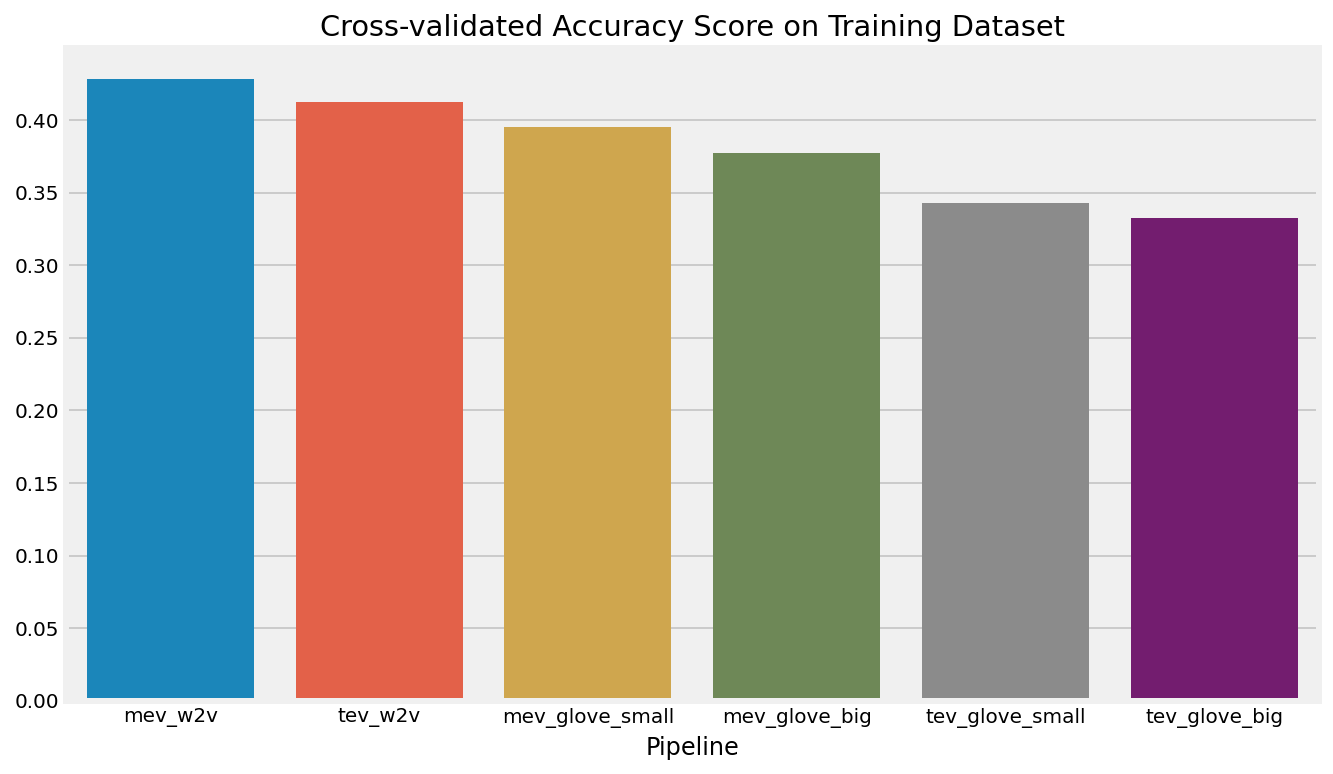

In [61]:
plt.figure(figsize=(10, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores]);
plt.title("Cross-validated Accuracy Score on Training Dataset")
plt.xlabel("Pipeline");

<div class="alert alert-block alert-info">
As shown above, the <b>Mean Embedding Vectorizer</b> (mev) performs best together with the <b>Word2Vec</b> (w2v) word embedding based on the training dataset vocabulary, as it scores the highest in terms of the cross-validated accuracy score.<br>

We now evaluate two options for identifying the right classifier - a Forward Neural Network (FNN) and an Extra Trees Classifier.
</div>

## Finding the best classifier

### Creation of (Inner) Training and Validation Datasets

From our single training data set (X and y) we will create two separate datasets:
- (Inner) Training Dataset: this will be used to train our models (this will take 75% of the original training dataset)
- Validation Dataset: this will be used to validate our trained models (e.g. check for overfitting) (this will take 25% of our total 'posts' dataset

To create our datasets, we use train_test_split with the stratify option to ensure a consistent mix of values for the target feature within the created datasets.

In [20]:
# Restore the original predictor and target dataframes
X = X_original.copy()
y = y_original.copy()

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [22]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2490, 4323), (2490,), (831, 4323), (831,))

In [23]:
# Reset the indices to prevent spurious rows from appearing later during merging
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)

### Generation of word embeddings

In [24]:
# Instantiate a Mean Embedding Vectorizer object using the Word2Vec word embeddings
mev = MeanEmbeddingVectorizer(w2v)

In [25]:
%%time
X_train_mev = mev.fit(X_train['text'], y_train)
X_train_mev = mev.transform(X_train['text'])
X_val_mev = mev.transform(X_val['text'])
X_test_mev = mev.transform(X_test['text'])

Wall time: 2min 38s


In [26]:
X_train_mev.shape, X_val_mev.shape, X_test_mev.shape

((2490, 100), (831, 100), (986, 100))

In [27]:
X_train_mev_df = pd.DataFrame(X_train_mev)
X_val_mev_df = pd.DataFrame(X_val_mev)
X_test_mev_df = pd.DataFrame(X_test_mev)

In [28]:
X_train_mev_df.shape, X_val_mev_df.shape, X_test_mev_df.shape

((2490, 100), (831, 100), (986, 100))

In [29]:
X_train_mev_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.322890,1.858118,0.690987,1.380139,-2.073414,1.476854,0.341173,-0.844618,2.367725,-1.459497,...,-0.612501,0.337902,0.986099,-0.219501,-2.611684,-1.484770,-0.886926,-3.076670,-0.148434,0.287207
1,-0.422883,1.882263,0.559715,1.491729,-2.131850,1.493168,0.387113,-0.911156,2.340408,-1.613197,...,-0.709358,0.325872,1.095482,-0.183094,-2.564134,-1.414235,-0.919028,-3.195979,-0.048870,0.302353
2,-0.327176,1.904668,0.601967,1.461163,-2.089042,1.499087,0.404055,-0.825882,2.356344,-1.544889,...,-0.637951,0.307982,1.058155,-0.203846,-2.526697,-1.388882,-0.822508,-3.215563,-0.066309,0.206721
3,-0.370126,1.819429,0.601597,1.433822,-2.104804,1.484627,0.357159,-0.906271,2.284128,-1.584188,...,-0.701243,0.317997,1.056278,-0.169478,-2.514942,-1.389338,-0.821980,-3.131690,-0.067767,0.260677
4,-0.362326,1.832180,0.604159,1.383792,-2.083553,1.473238,0.370844,-0.882687,2.343976,-1.543756,...,-0.690165,0.325602,1.037598,-0.202474,-2.580307,-1.421439,-0.836938,-3.130956,-0.103290,0.243496


### Combining word vectors with dummy columns

In [30]:
# Concatenate the components parts of the dataframe
X_train = pd.concat([X_train, X_train_mev_df], axis=1)
X_val = pd.concat([X_val, X_val_mev_df], axis=1)
X_test = pd.concat([X_test, X_test_mev_df], axis=1)

In [31]:
X_train.drop(columns=['text'], inplace=True)
X_val.drop(columns=['text'], inplace=True)
X_test.drop(columns=['text'], inplace=True)

In [32]:
X_train.shape, X_val.shape, X_test.shape

((2490, 4422), (831, 4422), (986, 4422))

In [33]:
X_train.head()

,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,gene_AGXT,gene_AKAP9,gene_AKT1,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,-0.612501,0.337902,0.986099,-0.219501,-2.611684,-1.484770,-0.886926,-3.076670,-0.148434,0.287207
1,0,0,0,0,0,0,0,0,0,0,...,-0.709358,0.325872,1.095482,-0.183094,-2.564134,-1.414235,-0.919028,-3.195979,-0.048870,0.302353
2,0,0,0,0,0,0,0,0,0,0,...,-0.637951,0.307982,1.058155,-0.203846,-2.526697,-1.388882,-0.822508,-3.215563,-0.066309,0.206721
3,0,0,0,0,0,0,0,0,0,0,...,-0.701243,0.317997,1.056278,-0.169478,-2.514942,-1.389338,-0.821980,-3.131690,-0.067767,0.260677
4,0,0,0,0,0,0,0,0,0,0,...,-0.690165,0.325602,1.037598,-0.202474,-2.580307,-1.421439,-0.836938,-3.130956,-0.103290,0.243496


### Handling of imbalanced classes

In [34]:
y_train.value_counts(normalize=True)

7    0.287149
4    0.206426
1    0.171084
2    0.136145
6    0.082731
5    0.072691
3    0.026908
9    0.011245
8    0.005622
Name: class, dtype: float64

In [35]:
y_train.value_counts()

7    715
4    514
1    426
2    339
6    206
5    181
3     67
9     28
8     14
Name: class, dtype: int64

We follow the same oversampling strategy as per the baseline model -- i.e. to use SMOTE to oversample the 3 most infrequent classes to be 100 samples each.

In [36]:
# Instantiate a SMOTE object to oversample minority classes
sm = SMOTE(random_state=42, sampling_strategy={3:100, 9:100, 8:100})

In [37]:
%%time
X_train, y_train = sm.fit_sample(X_train, y_train)

Wall time: 7.87 s


In [38]:
X_train.shape, y_train.shape

((2681, 4422), (2681,))

In [39]:
# Verify that we now have 181 samples for classes '5', '3' and '8'.
y_train.value_counts()

7    715
4    514
1    426
2    339
6    206
5    181
9    100
3    100
8    100
Name: class, dtype: int64

### Scaling the data

In [40]:
ms = MinMaxScaler()

In [41]:
ms.fit(pd.concat([X_train, X_val])) # we fit the StandardScaler based on all our training and validation data
X_train = ms.transform(X_train)
X_val = ms.transform(X_val)
X_test = ms.transform(X_test)

## Exploring Classifier Option #1: Forward Neural Network (FNN)

In [42]:
# replace y with categorical features
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [43]:
# remove the first column because it is redundant
y_train_cat = np.delete(y_train_cat, 0, axis=1) 
y_val_cat = np.delete(y_val_cat, 0, axis=1) 

In [44]:
y_train_cat.shape, y_val_cat.shape

((2681, 9), (831, 9))

To achieve reasonable execution times, we adopt a two stage approach to finding the optimal parameters for the FNN:
- **Stage 1**: We use RandomisedSearchCV to find the optimal parameters for a FNN with two hidden layers, except for the number of epochs. The RandomizedSearch CV chooses the optimal parameters to get the best 5-fold cross-validation score on the training set. We assume that the actual best parameters can be found within 5 epochs.
- **Stage 2**: We redefine our FNN with the optimal parameters identified in Stage 1, but use an Early Stopping callback to terminate the training based on the lowest validation loss found.

### Stage 1: Use Randomised Search to find optimal parameters (excl. number of epochs)

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = X_unique_words, output_dim = 1000, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(max_phrase_len, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(max_phrase_len, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))

In [45]:
# X_train_padded = pad_sequences(X_train, padding='post', maxlen=max_phrase_len)

```
def model_func(embedding_vec_size=500, spatial_dropout=0.2,
               lstm_dropout=0.2, lstm_rec_dropout=0.2, layer_one_dropout=0.2,
               layer_two_neurons=250, layer_two_dropout=0.2, opt_learning_rate=0.001):
    
    model = Sequential()

    # model.add(Embedding(input_dim = len(X_unique_words), output_dim = embedding_vec_size, input_length = max_phrase_len))
    # model.add(SpatialDropout1D(spatial_dropout))
    model.add(LSTM(max_phrase_len,
                   dropout = lstm_dropout,
                   recurrent_dropout = lstm_rec_dropout,
                   return_sequences = True))
   
    model.add(Dense(max_phrase_len,activation='relu'))
    model.add(Dropout(layer_one_dropout))

    model.add(Dense(layer_two_neurons,activation='relu'))
    model.add(Dropout(layer_two_dropout))

    model.add(Dense(9,activation='softmax'))

    Ad = optimizers.Adam(learning_rate=opt_learning_rate,
                         beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='categorical_crossentropy',optimizer=Ad,metrics=['accuracy'])
    return model
```

In [53]:
def model_func(layer_one_neurons=3000, layer_one_dropout=0.2,
               layer_two_neurons=2000, layer_two_dropout=0.2, opt_learning_rate=0.001):

    model = Sequential()

    model.add(Dense(layer_one_neurons, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(layer_one_dropout))

    model.add(Dense(layer_two_neurons, activation='relu'))
    model.add(Dropout(layer_two_dropout))

    model.add(Dense(9,activation='softmax'))

    Ad = optimizers.Adam(learning_rate=opt_learning_rate,
                         beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='categorical_crossentropy',optimizer=Ad,metrics=['accuracy'])
    return model

In [54]:
nn = KerasClassifier(build_fn=model_func, epochs=10, verbose=2)

In [55]:
pipe= Pipeline([
    ('nn',nn)
])

In [56]:
params={
    # 'nn__embedding_vec_size': [400, 500, 600],
    # 'nn__spatial_dropout': [0.1, 0.2, 0.3],
    # 'nn__lstm_dropout': [0.1, 0.2, 0.3],
    # 'nn__lstm_rec_dropout': [0.1, 0.2, 0.3],
    'nn__layer_one_neurons': [2000, 3000, 4000],
    'nn__layer_one_dropout': [0.1, 0.2, 0.3],
    'nn__layer_two_neurons' : [1000, 2000, 3000],
    'nn__layer_two_dropout': [0.1, 0.2, 0.3],
    'nn__opt_learning_rate' : [0.001, 0.0001]
}

In [57]:
rs = RandomizedSearchCV(pipe, param_distributions = params, verbose=1, cv=3, random_state=42)

In [58]:
%%time
now = datetime.datetime.now()
print ("Started fitting at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
rs.fit(X_train, y_train_cat)

Started fitting at: 2020-04-06 00:14:34
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
 - 16s - loss: 1.9775 - accuracy: 0.3039
Epoch 2/10
 - 17s - loss: 1.5896 - accuracy: 0.4477
Epoch 3/10
 - 16s - loss: 1.2342 - accuracy: 0.5691
Epoch 4/10
 - 16s - loss: 0.9734 - accuracy: 0.6766
Epoch 5/10
 - 16s - loss: 0.7557 - accuracy: 0.7448
Epoch 6/10
 - 17s - loss: 0.4892 - accuracy: 0.8556
Epoch 7/10
 - 16s - loss: 0.3153 - accuracy: 0.8982
Epoch 8/10
 - 16s - loss: 0.2370 - accuracy: 0.9273
Epoch 9/10
 - 16s - loss: 0.1645 - accuracy: 0.9496
Epoch 10/10
 - 16s - loss: 0.1618 - accuracy: 0.9480
Epoch 1/10
 - 16s - loss: 1.9911 - accuracy: 0.2910
Epoch 2/10
 - 16s - loss: 1.6267 - accuracy: 0.4163
Epoch 3/10
 - 17s - loss: 1.2711 - accuracy: 0.5473
Epoch 4/10
 - 17s - loss: 1.0386 - accuracy: 0.6217
Epoch 5/10
 - 17s - loss: 0.7879 - accuracy: 0.7247
Epoch 6/10
 - 18s - loss: 0.5557 - accuracy: 0.8304
Epoch 7/10
 - 18s - loss: 0.3712 - accuracy: 0.8875
Epoch 8/10
 - 18s - loss: 0.2516 - accuracy: 0.9172
Epoch 9/10
 - 18s - loss: 0.1839 - accuracy: 0.9440
Epoch 10/10

Epoch 10/10
 - 15s - loss: 0.4789 - accuracy: 0.8948
Epoch 1/10
 - 15s - loss: 2.0016 - accuracy: 0.2742
Epoch 2/10
 - 14s - loss: 1.8332 - accuracy: 0.3721
Epoch 3/10
 - 15s - loss: 1.6194 - accuracy: 0.4773
Epoch 4/10
 - 15s - loss: 1.3698 - accuracy: 0.5568
Epoch 5/10
 - 15s - loss: 1.1604 - accuracy: 0.6161
Epoch 6/10
 - 15s - loss: 0.9976 - accuracy: 0.6844
Epoch 7/10
 - 15s - loss: 0.8520 - accuracy: 0.7465
Epoch 8/10
 - 15s - loss: 0.7256 - accuracy: 0.8019
Epoch 9/10
 - 15s - loss: 0.5933 - accuracy: 0.8422
Epoch 10/10
 - 14s - loss: 0.5031 - accuracy: 0.8691
Epoch 1/10
 - 15s - loss: 1.8465 - accuracy: 0.2975
Epoch 2/10
 - 14s - loss: 1.6650 - accuracy: 0.4251
Epoch 3/10
 - 15s - loss: 1.4222 - accuracy: 0.5375
Epoch 4/10
 - 15s - loss: 1.2026 - accuracy: 0.6023
Epoch 5/10
 - 15s - loss: 1.0268 - accuracy: 0.6812
Epoch 6/10
 - 15s - loss: 0.9053 - accuracy: 0.7097
Epoch 7/10
 - 15s - loss: 0.7631 - accuracy: 0.7796
Epoch 8/10
 - 15s - loss: 0.6292 - accuracy: 0.8261
Epoch 9/10

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 80.5min finished


Epoch 1/10
 - 30s - loss: 1.9205 - accuracy: 0.3073
Epoch 2/10
 - 30s - loss: 1.6308 - accuracy: 0.4636
Epoch 3/10
 - 30s - loss: 1.3334 - accuracy: 0.5558
Epoch 4/10
 - 30s - loss: 1.1204 - accuracy: 0.6322
Epoch 5/10
 - 29s - loss: 0.9367 - accuracy: 0.7057
Epoch 6/10
 - 30s - loss: 0.7880 - accuracy: 0.7542
Epoch 7/10
 - 30s - loss: 0.6353 - accuracy: 0.8139
Epoch 8/10
 - 30s - loss: 0.5001 - accuracy: 0.8717
Epoch 9/10
 - 29s - loss: 0.3911 - accuracy: 0.9075
Epoch 10/10
 - 30s - loss: 0.3022 - accuracy: 0.9340
Wall time: 1h 25min 36s


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('nn',
                                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001DC57CE4D88>)],
                                      verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'nn__layer_one_dropout': [0.1, 0.2,
                                                                  0.3],
                                        'nn__layer_one_neurons': [2000, 3000,
                                                                  4000],
                                        'nn__layer_two_dropout': [0.1, 0.2,
                                                                  0.3],
                                        'nn__layer_two_neurons': [1000, 2000,
                                                                  3000],
                  

In [59]:
print(rs.best_score_)
print(rs.best_params_)

0.5587250391642252
{'nn__opt_learning_rate': 0.0001, 'nn__layer_two_neurons': 3000, 'nn__layer_two_dropout': 0.2, 'nn__layer_one_neurons': 4000, 'nn__layer_one_dropout': 0.2}


### Stage 2: Use Early Stopping callback to find optimal number of epochs

We now instantiate an updated version of our FNN above based on the optimal parameters, but adjust our model fitting to include an Early Stopping callback so that we can stop the training to minimise overfitting.

In [60]:
# We redefine the FNN based on the optimal parameters obtained via RandomisedSearchCV above
seq_model = Sequential()
seq_model.add(Dense(4000, activation='relu', input_dim=X_train.shape[1]))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(3000, activation='relu'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(9, activation='softmax'))

In [61]:
# Establish early stopping callback to stop training based on validation loss
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2)

In [62]:
seq_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=0.0001, beta_2=0.999, amsgrad=False),
                  metrics=['accuracy'])
seq_history = seq_model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),
                            epochs=50, callbacks=[early_stop], batch_size=256, verbose=1)

Train on 2681 samples, validate on 831 samples
Epoch 1/50
2681/2681 [==============================] - 5s 2ms/step - loss: 2.0173 - accuracy: 0.2566 - val_loss: 1.8272 - val_accuracy: 0.3562
Epoch 2/50
2681/2681 [==============================] - 5s 2ms/step - loss: 1.9228 - accuracy: 0.2850 - val_loss: 1.8012 - val_accuracy: 0.4152
Epoch 3/50
2681/2681 [==============================] - 5s 2ms/step - loss: 1.8485 - accuracy: 0.3797 - val_loss: 1.7144 - val_accuracy: 0.4128
Epoch 4/50
2681/2681 [==============================] - 5s 2ms/step - loss: 1.7532 - accuracy: 0.4207 - val_loss: 1.6143 - val_accuracy: 0.4862
Epoch 5/50
2681/2681 [==============================] - 5s 2ms/step - loss: 1.6322 - accuracy: 0.5017 - val_loss: 1.5337 - val_accuracy: 0.5162
Epoch 6/50
2681/2681 [==============================] - 5s 2ms/step - loss: 1.5067 - accuracy: 0.5360 - val_loss: 1.4550 - val_accuracy: 0.5150
Epoch 7/50
2681/2681 [==============================] - 5s 2ms/step - loss: 1.3805 - accu

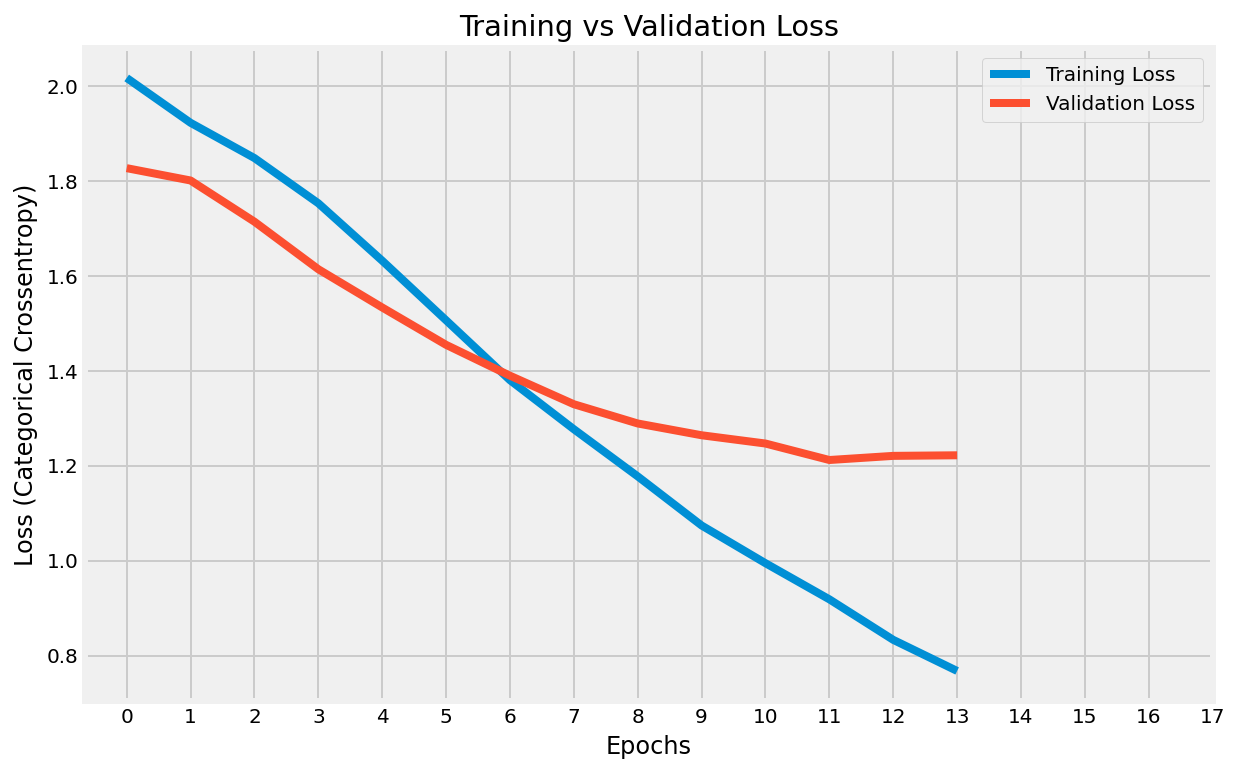

In [66]:
# Plot training vs validation loss
plt.figure(figsize=(9,6))
plt.title("Training vs Validation Loss")
plt.plot(seq_history.history['loss'], label="Training Loss")
plt.plot(seq_history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (Categorical Crossentropy)")
plt.xticks(np.arange(0, 18, step=1))
plt.legend();

In [67]:
# Display validation loss and accuracy
seq_score = seq_model.evaluate(X_val, y_val_cat, verbose=1)
seq_labels = seq_model.metrics_names
print ("Validation {}: {}".format(seq_labels[0], seq_score[0]))
print ("Validation {}: {}".format(seq_labels[1], seq_score[1]))

831/831 [==============================] - 0s 552us/step
Validation loss: 1.2222408904065294
Validation accuracy: 0.588447630405426


## Exploring Classifier Option #2: Extra Trees Classifier

To manage the total time and resources used to tune the classifier parameters, we use the RandomizedSearchCV to find the optimum parameters for the Extra Trees classifier to give the best 3-way cross-validated accuracy score on the training set, within a maximum of 10 iterations. We did not consider other classifiers due to the limitations of processing power and memory. Additional classifiers could be evaluated as a next step to this Capstone project, akin to the range of classifiers that were evaluated to find the baseline classifier.

In [115]:
# We have selected the models below for modelling purposes.
estimators = {
    'etree': ExtraTreesClassifier(random_state=42),
}.items()

In [116]:
params = {
    'etree': {
        'etree__n_estimators': [150, 200, 250],
        'etree__max_features': ['auto', 'sqrt', 'log2', None],
        'etree__min_samples_split': [4, 6, 8],
        'etree__min_samples_leaf': [2, 3, 4]
    }
}

We now use RandomizedSearchCV to select the optimal parameters for each classifier that produces the best mean cross-validated accuracy score based on the training dataset.

In [117]:
%%time
# initialise empty lists to store information later
models = []
parameters = []
train_accuracy = []
val_accuracy = []
best_score = []
train_roc_auc = []
val_roc_auc = []
sensitivity = []

for k,v in estimators:
    start = time.time()
    pipe = Pipeline([(k,v)])
    param = params[k]
    randomsearch = RandomizedSearchCV(
        n_iter=10, # we set a max. of 10 iterations
        estimator=pipe,
        random_state=42,
        param_distributions=param,
        verbose=1,
        cv= 5,
        # We limit the no. of jobs to ensure sufficient memory for successful execution
        n_jobs=4,
        return_train_score= True,
        # RandomizedSearchCV will use best cross-validation accuracy score to determine best parameters
        scoring = 'accuracy' 
    )

    randomsearch.fit(X_train, y_train)
    
    model = randomsearch.best_estimator_
    cv_score = randomsearch.cv_results_
    best_params = randomsearch.best_params_

    # predict y
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # print results
    print ("Model: ", k)
    print ("Fitting time (h:m:s): {}".format(str(datetime.timedelta(seconds=time.time()-start))))
    print ("Best parameters:", best_params)
    print ("Best accuracy cross validation score:", randomsearch.best_score_)
    print ("Training dataset accuracy:", accuracy_score(y_train,y_pred_train))
    print ("Validation dataset accuracy:", accuracy_score(y_val,y_pred_val))
    print ("")
    
    # append info to list
    models.append(k)
    best_score.append(randomsearch.best_score_)
    parameters.append(best_params)
    train_accuracy.append(accuracy_score(y_train,y_pred_train))
    val_accuracy.append(accuracy_score(y_val,y_pred_val))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 61.4min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 70.3min finished


Model:  etree
Fitting time (h:m:s): 1:14:50.765381
Best parameters: {'etree__n_estimators': 250, 'etree__min_samples_split': 4, 'etree__min_samples_leaf': 2, 'etree__max_features': None}
Best accuracy cross validation score: 0.681098696461825
Training dataset accuracy: 0.9127191346512495
Validation dataset accuracy: 0.6486161251504212

Wall time: 1h 14min 50s


In [87]:
# Produce a summary table of the tuned classifier(s)
summary = pd.DataFrame({
    'model': models,
    'parameters': parameters,
    'Best accuracy cross validation score': best_score,
    'Training dataset accuracy': train_accuracy,
    'Validation dataset accuracy': val_accuracy
    })

pd.set_option('display.max_colwidth', None)
summary.sort_values('Validation dataset accuracy', ascending=False).reset_index(drop=True)

NameError: name 'models' is not defined

## Confirmation of Alternative Model

<div class="alert alert-block alert-info">
    
Comparing the validation dataset accuracy, we have:
    <ul>
        <li> `0.58845` for FNN Classifier</li>
        <li> `0.64862` for the Extra Trees Classifier</li>
    </ul>
<br>
    Based on the highest score above, our best alternative model is therefore the <b>Extra Trees classifier</b> trained on <b>Word2Vec word embeddings</b> using the <b>Mean Embedding Vectorizer</b>.

We note that the validation (dataset) accuracy of this model (`0.64862`) is <b>lower</b> than the baseline model (`0.66787`), which suggests that the alternative model is <b>more overfitted</b> than the baseline model. We now generate predictions based on the chosen alternative model so that we can obtain the Kaggle score in notebook 5.
</div>

## Further Exploration of Alternative Model

In [71]:
# We instantiate the best classifier based on the best parameters found above
alternative_clf = ExtraTreesClassifier(verbose=1, n_jobs=4, random_state=42, n_estimators=250,
                                       min_samples_split=4, min_samples_leaf=2, max_features=None)

In [72]:
%%time
# Fit the best classifier on the training dataset
alternative_clf.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.3s


Wall time: 25.6 s


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:   25.3s finished


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features=None,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=2, min_samples_split=4,
                     min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=4,
                     oob_score=False, random_state=42, verbose=1,
                     warm_start=False)

### ROC Curve & Metrics

In [73]:
# Generate predictions for the validation data based on our baseline model
y_val_pred = alternative_clf.predict(X_val)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.0s finished


In [121]:
# Binarize the output
y_train_binarized = label_binarize(y_train, classes=list(np.unique(y)))
y_val_pred_binarized = label_binarize(y_val_pred, classes=list(np.unique(y)))
n_classes = len(np.unique(y))

In [122]:
%%time
now = datetime.datetime.now()
print ("Started fitting at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
# We obtain the distances of each sample from the decision boundary for each class
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=42, verbose=1), n_jobs=2)
y_score = classifier.fit(X_train, y_train_binarized).decision_function(X_val)

Wall time: 13min 14s


In [123]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # we compare our predicted labels for the validation dataset and the actual validation dataset labels
    fpr[i], tpr[i], _ = roc_curve(y_val_pred_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_pred_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

We plot ROC curves for all the 9 classes.

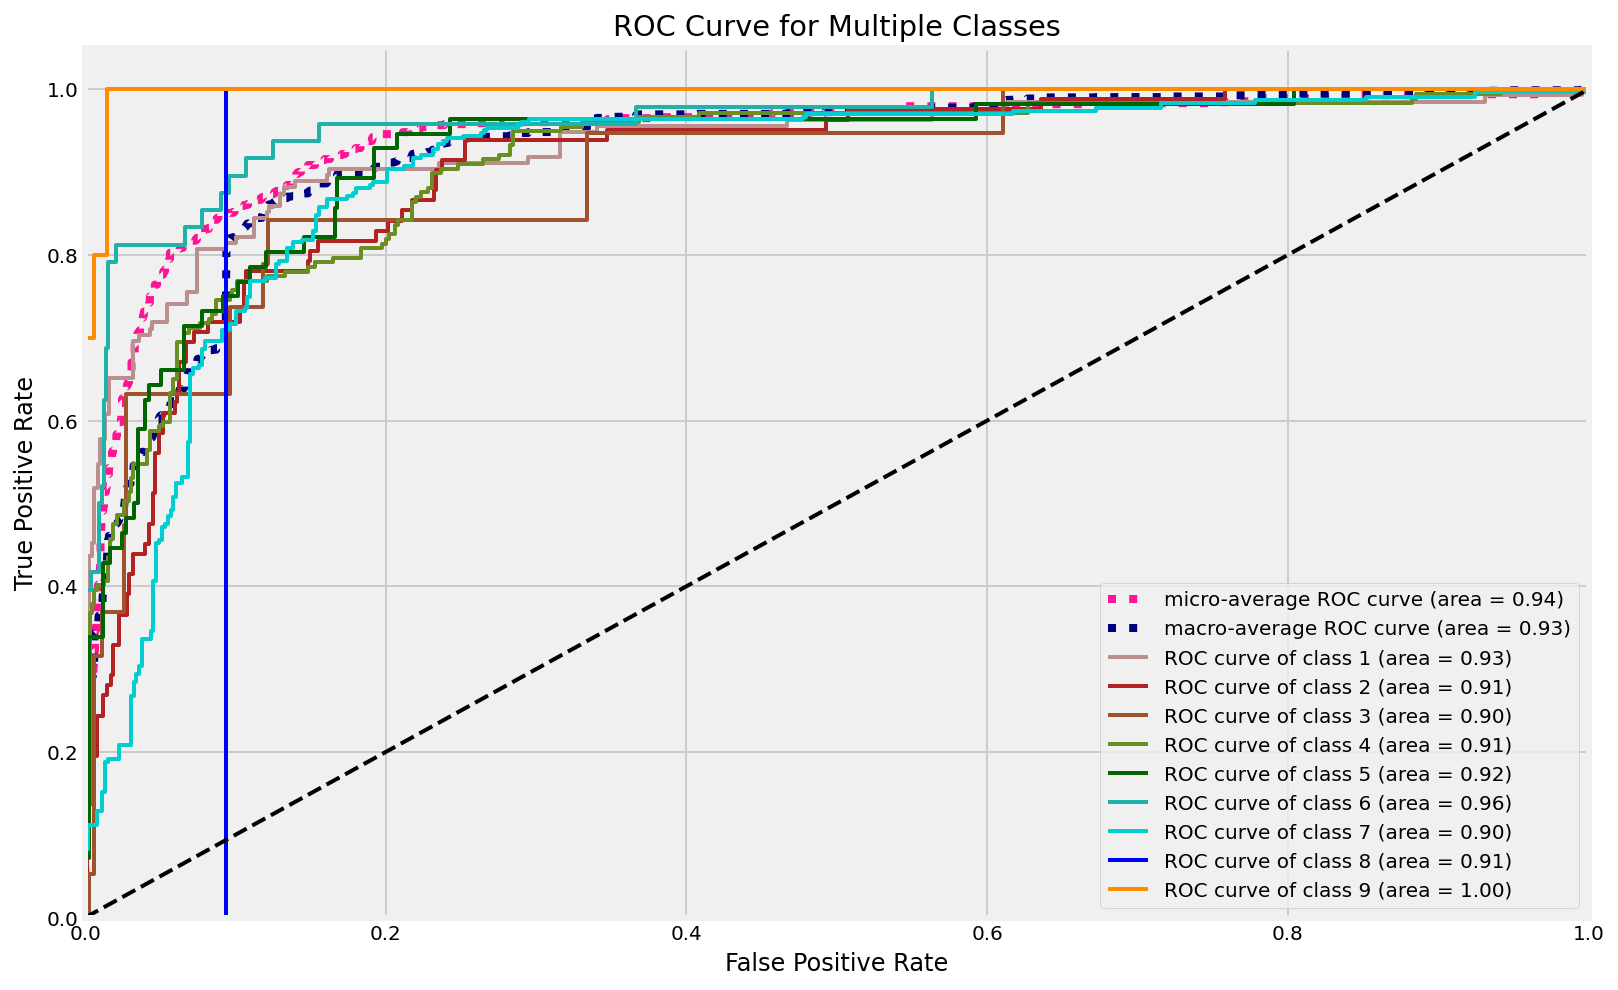

In [124]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

lw=2
colors = cycle(['rosybrown', 'firebrick', 'sienna', 'olivedrab', 'darkgreen',\
                'lightseagreen', 'darkturquoise', 'b', 'darkorange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiple Classes')
plt.legend(loc="lower right")
plt.show()

We observe above that the AUC scores for all the 9 classes are very high, even though the classes in the original training dataset were highly imbalanced.

In [77]:
# summarize class distribution
print (Counter(y_val_pred))

Counter({7: 307, 4: 173, 1: 132, 2: 83, 6: 52, 5: 52, 3: 19, 9: 11, 8: 2})


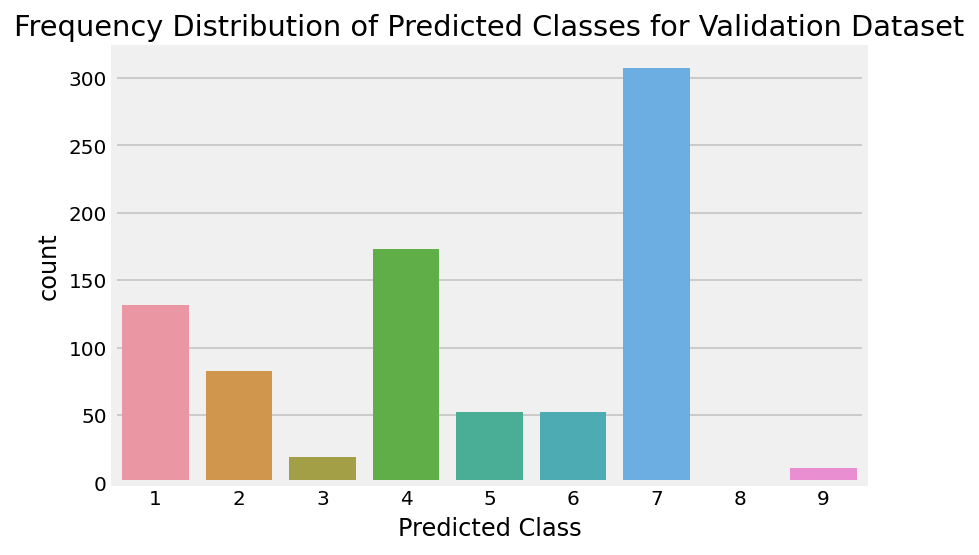

In [75]:
plt.figure()
plt.title("Frequency Distribution of Predicted Classes for Validation Dataset")
sns.countplot(y_val_pred)
plt.xlabel("Predicted Class");

In [80]:
# Print classification report
target_names = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                'class 6', 'class 7', 'class 8', 'class 9']
print(classification_report(y_val, y_val_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.68      0.63      0.66       142
     class 2       0.61      0.45      0.52       113
     class 3       0.37      0.32      0.34        22
     class 4       0.70      0.70      0.70       172
     class 5       0.37      0.31      0.34        61
     class 6       0.79      0.59      0.68        69
     class 7       0.65      0.84      0.73       238
     class 8       0.00      0.00      0.00         5
     class 9       0.64      0.78      0.70         9

    accuracy                           0.64       831
   macro avg       0.53      0.51      0.52       831
weighted avg       0.64      0.64      0.63       831



We now display the balanced accuracy based on the validation dataset, which can cater to imbalanced datasets. It is defined as the weighted average of recall obtained on each class.

In [88]:
print ("Balanced accuracy score: {}".format(metrics.balanced_accuracy_score(y_val, y_val_pred)))

Balanced accuracy score: 0.5140434423056277


## Evaluation of Alternative Model vs Baseline Model

<div class="alert alert-block alert-info">
    
(To be written)
    
</div>

## Data Export (for Kaggle Submission)

In [81]:
y_test_pred = alternative_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.0s finished


In [82]:
y_test_pred.shape

(986,)

In [83]:
# Restore the 'id' column since we need this for the Kaggle submission
test_pred = pd.concat([test['id'], pd.DataFrame(y_test_pred, columns=['class'])], axis=1)

In [84]:
# Verify that we have a mix of predictions for variation classes
test_pred['class'].value_counts()

7    584
4    158
1    118
2     58
5     25
6     19
3     10
8      9
9      5
Name: class, dtype: int64

In [85]:
test_pred.head()

,id,class
0,1,4
1,2,1
2,3,7
3,4,1
4,5,7


In [86]:
# We export the predictions
test_pred.to_csv("../assets/test_pred.csv", index=False)